### Imports

In [1]:
import preprocessing
import pandas as pd
import evaluation as evaluation
from sklearn.model_selection import train_test_split
import nltk
import model
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
nltk.download('punkt')
import pandas as pd
import zipfile
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Trainingdata

In [2]:
path = "data\spam2-train.zip"
input, labels,_ = preprocessing.load_data(path)
df = pd.DataFrame({'raw': input, 'label': labels})
df.head()

,raw,label
0,From perl6-all-return-80775-ktwarwic=speedy.uw...,0
1,From bdfhjid@comcast.net Tue Apr 10 21:05:17 ...,1
2,From Jaime.Potter8239@kotnet.org Sat May 5 0...,1
3,From extraelec@godial.com Sun May 20 03:13:37...,1
4,From vtqmerrick@mail2greece.com Mon Apr 16 07...,1


### Analyze and Preprocess Data

In [3]:
df['content_dict'], df['subject'] = zip(*df['raw'].apply(preprocessing.extract_email_content))
df.head()

,raw,label,content_dict,subject
0,From perl6-all-return-80775-ktwarwic=speedy.uw...,0,"{'text/plain': 'Ok, so I see now that reg_allo...",Re: I Don't Understand The Context Allocation/...
1,From bdfhjid@comcast.net Tue Apr 10 21:05:17 ...,1,"{'text/html': '<!DOCTYPE HTML PUBLIC ""-//W3C//...",Rocket Stock Report
2,From Jaime.Potter8239@kotnet.org Sat May 5 0...,1,{'text/html': '<HTML><HEAD> <META http-equ...,New vacancies in our company. [letter id: y036...
3,From extraelec@godial.com Sun May 20 03:13:37...,1,{'text/plain': 'FDA approved on-line pharmacie...,FDA approved on-line pharmacies
4,From vtqmerrick@mail2greece.com Mon Apr 16 07...,1,{'text/plain': 'Does Size Matter7 _____ 60% o...,No lickingville do mossville


In [4]:
# content type indicator for spam? for each content type, how many spam emails have it?
spam_content_type = df.groupby('label')['content_dict'].apply(lambda x: x.apply(lambda y: list(y.keys())).explode().value_counts())
spam_content_type 

label                             
0      text/plain                      5071
       text/html                       1224
       application/pgp-signature        149
       image/gif                         96
       image/jpeg                        77
       Attachment                        75
       application/octet-stream          74
       text/plain charset=us-ascii       29
       text/x-patch                      11
       text/x-diff                        6
       application/x-gzip                 2
       image/png                          2
       application/pdf                    1
       plain/text                         1
1      text/html                      10363
       text/plain                      8434
       image/gif                       1842
       image/jpeg                       649
       image/png                        103
       Attachment                        15
       application/x-msdownload           6
       text/rfc822-headers               

In [5]:
# List of content types to set values for
content_types = [
    'image/gif',
    'image/jpeg',
    'application/x-msdownload',
    'application/octet-stream',
    'image/png',
    'application/pgp-signature',
    'image/jpg',
    'text/x-patch',
    'application/x-gzip',
    'multipart/alternative',
    'text/plain charset=us-ascii',
    'text/x-diff'
]

# Update the content_dict
for content_type in content_types:
    if content_type in df["content_dict"]:
        df["content_dict"][content_type] = content_type  # Set the value to the key name

# Print the updated content_dict
print(df["content_dict"])


0        {'text/plain': 'Ok, so I see now that reg_allo...
1        {'text/html': '<!DOCTYPE HTML PUBLIC "-//W3C//...
2        {'text/html': '<HTML><HEAD>
<META     http-equ...
3        {'text/plain': 'FDA approved on-line pharmacie...
4        {'text/plain': 'Does Size Matter7
_____

60% o...
                               ...                        
18751    {'text/plain': '
Anatrim  The up-to-the-moment...
18752    {'text/plain': 'Gene Collins wrote:
>> I'm not...
18753    {'text/plain': '
Hello,

I'm trying to sort my...
18754    {'text/plain': 'Hello my friend!I am ready to ...
18755    {'text/plain': '
 
 


Lord Wilmore.Let exampl...
Name: content_dict, Length: 18756, dtype: object


In [6]:
df["subject_preprocessed"] = df["subject"].apply(preprocessing.normalize_string)
df["content_dict_preprocessed"] = df["content_dict"].apply(lambda d: {k: preprocessing.normalize_string(v) for k, v in d.items()})
df['combined_text'] = df['subject_preprocessed'] + ' ' + df['content_dict_preprocessed'].apply(lambda x: ' '.join(x.values()))
df

,raw,label,content_dict,subject,subject_preprocessed,content_dict_preprocessed,combined_text
0,From perl6-all-return-80775-ktwarwic=speedy.uw...,0,"{'text/plain': 'Ok, so I see now that reg_allo...",Re: I Don't Understand The Context Allocation/...,re i dont understand the context allocationdes...,{'text/plain': 'ok so i see now that regalloc ...,re i dont understand the context allocationdes...
1,From bdfhjid@comcast.net Tue Apr 10 21:05:17 ...,1,"{'text/html': '<!DOCTYPE HTML PUBLIC ""-//W3C//...",Rocket Stock Report,rocket stock report,{'text/html': 'doctype html public wcdtd html ...,rocket stock report doctype html public wcdtd ...
2,From Jaime.Potter8239@kotnet.org Sat May 5 0...,1,{'text/html': '<HTML><HEAD> <META http-equ...,New vacancies in our company. [letter id: y036...,new vacancies in our company letter id yfu,{'text/html': 'htmlhead meta httpequivcontentt...,new vacancies in our company letter id yfu htm...
3,From extraelec@godial.com Sun May 20 03:13:37...,1,{'text/plain': 'FDA approved on-line pharmacie...,FDA approved on-line pharmacies,fda approved online pharmacies,{'text/plain': 'fda approved online pharmacies...,fda approved online pharmacies fda approved on...
4,From vtqmerrick@mail2greece.com Mon Apr 16 07...,1,{'text/plain': 'Does Size Matter7 _____ 60% o...,No lickingville do mossville,no lickingville do mossville,{'text/plain': 'does size matter of women said...,no lickingville do mossville does size matter ...
...,...,...,...,...,...,...,...
18751,From hoqdasmithmac@dasmith.com Fri Apr 27 20:...,1,{'text/plain': ' Anatrim The up-to-the-moment...,Losing weight has never been so easy,losing weight has never been so easy,{'text/plain': 'anatrim the uptothemoment and ...,losing weight has never been so easy anatrim t...
18752,From speakup-bounces@braille.uwo.ca Wed May 1...,0,{'text/plain': 'Gene Collins wrote: >> I'm not...,Re: heretical thoughts was Re: Speakup dropped...,re heretical thoughts was re speakup dropped f...,{'text/plain': 'gene collins wrote im not qual...,re heretical thoughts was re speakup dropped f...
18753,From r-help-bounces@stat.math.ethz.ch Tue May...,0,"{'text/plain': ' Hello, I'm trying to sort my...",[R] sorting in barplot,r sorting in barplot,{'text/plain': 'hello im trying to sort my bar...,r sorting in barplot hello im trying to sort m...
18754,From ammc@1000movein.com Mon Apr 30 10:50:16 ...,1,{'text/plain': 'Hello my friend!I am ready to ...,Your medicine is ready and waiting for you,your medicine is ready and waiting for you,{'text/plain': 'hello my friendi am ready to k...,your medicine is ready and waiting for you hel...


In [7]:
import numpy as np


content_features = df['content_dict'].apply(preprocessing.extract_content_features)
structured_features = np.array(content_features.tolist())


### Split dataset

In [8]:
X_unstructured_train, X_unstructured_test, X_structured_train, X_structured_test, y_train, y_test = train_test_split(
    df['combined_text'], structured_features, df['label'], test_size=0.2, random_state=42
)

### Prepare data for neural network

In [9]:
mean_len = int(X_unstructured_train.apply(lambda x: len(x.split())).mean()  )
train_sequences, test_sequences, tokenizer = model.prepare_sequences(X_unstructured_train, X_unstructured_test, mean_len)
word_index = tokenizer.word_index


In [49]:
es = EarlyStopping(patience=6,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
 
lr = ReduceLROnPlateau(patience = 6,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [51]:
# Define parameters
input_dim = len(word_index) + 1  # Vocabulary size
embedding_dim = 200  
lstm_units = 256  
dense_units = 64  
unstructured_len = mean_len  
structured_len = X_structured_train.shape[1]

# Build the model
spam_model = model.build_model(name="Spam_Model", 
                          input_dim=input_dim, 
                          embedding_dim=embedding_dim, 
                          lstm_units=lstm_units, 
                          dense_units=dense_units, 
                          unstructured_len=unstructured_len,
                          structured_len=structured_len)

Model: "Spam_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 392)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 392, 200)  │ 70,329,400 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    467,968 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      1,216 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 320)       │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        321 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,798,905 (270.08 MB)

 Trainable params: 70,798,905 (270.08 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:

history = spam_model.fit([train_sequences, X_structured_train], y_train, epochs=20, batch_size=128, validation_split=0.15,callbacks = [lr, es])


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.6827 - loss: 0.5925 - val_accuracy: 0.7574 - val_loss: 0.4341 - learning_rate: 0.0010
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.7698 - loss: 0.4642 - val_accuracy: 0.8187 - val_loss: 0.3720 - learning_rate: 0.0010
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.8267 - loss: 0.3570 - val_accuracy: 0.8365 - val_loss: 0.3245 - learning_rate: 0.0010
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.8418 - loss: 0.3119 - val_accuracy: 0.9489 - val_loss: 0.2457 - learning_rate: 0.0010
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.9293 - loss: 0.1980 - val_accuracy: 0.9409 - val_loss: 0.2054 - learning_rate: 0.0010
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.9632 - loss: 0.1328 - val_accuracy: 0.9702 - val_loss: 0.0919 - learning_rate: 0.0010
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.9768 - loss: 0.

### Evaluate the model

In [55]:
test_loss, test_accuracy = spam_model.evaluate([test_sequences,X_structured_test], y_test)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

118/118 ━━━━━━━━━━━━━━━━━━━━ 50s 422ms/step - accuracy: 0.9813 - loss: 0.0892
Test Loss : 0.08985635638237
Test Accuracy : 0.9816098213195801


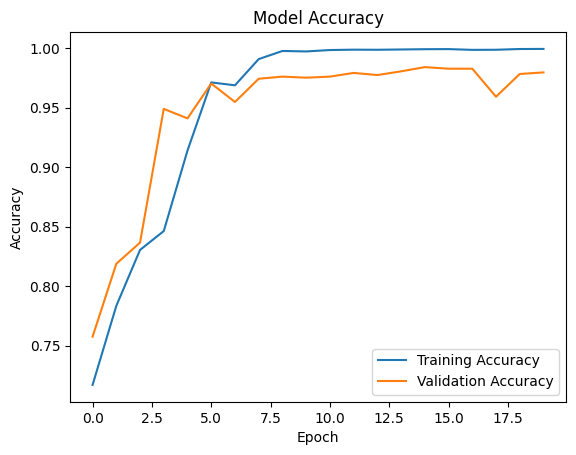

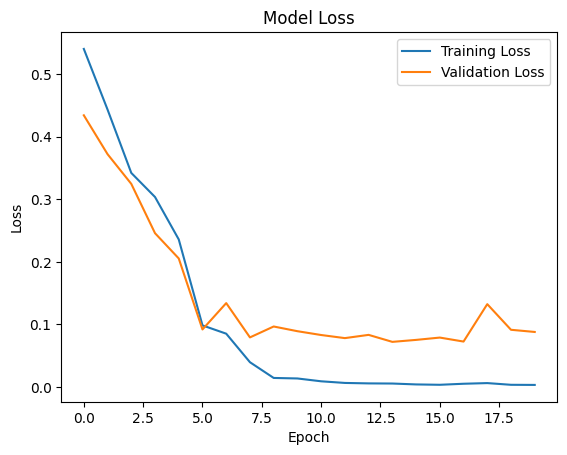

(None, None)

In [56]:
evaluation.plot_model_accuracy(history), evaluation.plot_model_loss(history)

### Test Model

In [57]:
prediction = spam_model.predict([test_sequences, X_structured_test])
prediction = [1 if p > 0.5 else 0 for p in prediction]

118/118 ━━━━━━━━━━━━━━━━━━━━ 46s 375ms/step


In [59]:
#compare the prediction with the actual label
result = pd.DataFrame({'unstructured_input': X_unstructured_test, 'label': y_test, 'prediction': prediction})
result

,unstructured_input,label,prediction
326,re request for suggestions of dfsgfree documen...,0,0
5659,super erection vigramax scientist revealed tha...,1,1
18121,with cab from atonal hellish report is here ta...,1,1
13217,all products for your health doctype html publ...,1,1
4720,beware of fake pills see attachment for more i...,1,1
...,...,...,...
15765,re svn commit samba r in branchessambasourceut...,0,0
168,cnn breaking news nbc is suspending its broadc...,0,0
8091,a simple and safe way to weigh less profit by ...,1,1
1336,corel draw oem software throw packing case lea...,1,1


Accuracy: 0.9816098081023454
Precision: 0.9814323607427056
Recall: 0.9923371647509579
F1 Score: 0.9868546389788531
Balanced Accuracy: 0.9747149921828344


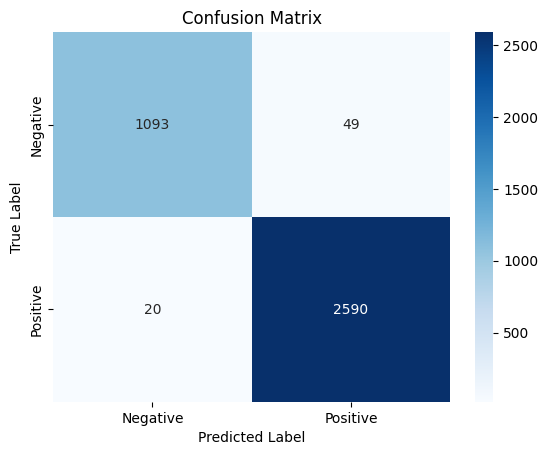


Classification Report:

              precision    recall  f1-score   support

    Negative       0.98      0.96      0.97      1142
    Positive       0.98      0.99      0.99      2610

    accuracy                           0.98      3752
   macro avg       0.98      0.97      0.98      3752
weighted avg       0.98      0.98      0.98      3752



In [60]:
evaluation.evaluate_model_performance(prediction,y_test)

In [54]:
#save the model
spam_model.save('spam_filter/model_2.keras')

### Analyze Errors

In [61]:
false_predictions = result[result['label'] != result['prediction']]
false_predictions.head()

,unstructured_input,label,prediction
4907,re r runing r in a bash script on wed apr ulri...,0,1
10254,re problems with dfs and samba please help jer...,0,1
5000,hannah storm country music mecca httpwwwcbsnew...,0,1
4338,iphealth indian pharma firms corner chunk of u...,0,1
16716,valued email subscriber update to ensure that ...,1,0


C:\Users\marle\AppData\Local\Temp\ipykernel_31972\216438021.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_predictions['text_length'] = false_predictions['unstructured_input'].apply(len)


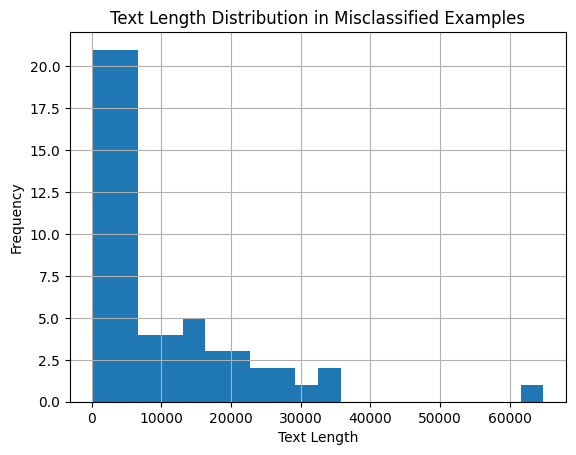

In [63]:

false_predictions['text_length'] = false_predictions['unstructured_input'].apply(len)
false_predictions['text_length'].hist(bins=20)
plt.title('Text Length Distribution in Misclassified Examples')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [10]:
#load model
spam_model = load_model('spam_filter/model_2.keras')

In [14]:
# Load the data
path = "data/spam2-test.zip"
input, filenames = preprocessing.load_test_data(path)
df = pd.DataFrame({'raw': input, 'output': filenames})


In [15]:
df['content_dict'], df['subject'] = zip(*df['raw'].apply(preprocessing.extract_email_content))
content_types = [
    'image/gif',
    'image/jpeg',
    'application/x-msdownload',
    'application/octet-stream',
    'image/png',
    'application/pgp-signature',
    'image/jpg',
    'text/x-patch',
    'application/x-gzip',
    'multipart/alternative',
    'text/plain charset=us-ascii',
    'text/x-diff'
]

# Update the content_dict
for content_type in content_types:
    if content_type in df["content_dict"]:
        df["content_dict"][content_type] = content_type  # Set the value to the key name


In [16]:
df["subject_preprocessed"] = df["subject"].apply(preprocessing.normalize_string)
df["content_dict_preprocessed"] = df["content_dict"].apply(lambda d: {k: preprocessing.normalize_string(v) for k, v in d.items()})
df['combined_text'] = df['subject_preprocessed'] + ' ' + df['content_dict_preprocessed'].apply(lambda x: ' '.join(x.values()))

content_features = df['content_dict'].apply(preprocessing.extract_content_features)
structured_features = np.array(content_features.tolist())

In [17]:

sequences = tokenizer.texts_to_sequences(df['combined_text'])
input_sequences = pad_sequences(sequences, maxlen=mean_len, padding='post', truncating='post')
predictions = spam_model.predict([input_sequences, structured_features])
predictions = [1 if p > 0.5 else 0 for p in predictions]


df

390/390 ━━━━━━━━━━━━━━━━━━━━ 60s 154ms/step


,raw,output,content_dict,subject,subject_preprocessed,content_dict_preprocessed,combined_text
0,From bounce-debian-legal=ktwarwic=speedy.uwate...,data/spam2-test/lgfoqlvnppicfvfq.x,"{'text/plain': 'On 6/24/07, Bruno Costacurta <...",Re: Copyright verification needed,re copyright verification needed,{'text/plain': 'on bruno costacurta pubmbskyne...,re copyright verification needed on bruno cost...
1,From greenkingclothing.com@kblans.com Fri Jun...,data/spam2-test/xjgjzojqglwcfsar.x,{'text/plain': ' See attachment. http://www.cl...,She will love you more than any other guy,she will love you more than any other guy,{'text/plain': 'see attachment httpwwwclaraoge...,she will love you more than any other guy see ...
2,From zet@idt.com Tue Jun 5 16:25:03 2007\nRe...,data/spam2-test/ucvumabybcfqqsha.x,"{'text/html': '<!DOCTYPE html PUBLIC ""-//W3C//...","Don't, don't stuff it with the keywords.",dont dont stuff it with the keywords,{'text/html': 'doctype html public wcdtd html ...,dont dont stuff it with the keywords doctype h...
3,From samba-technical-bounces+ktwarwic=speedy.u...,data/spam2-test/dnjtarwrjxiyongz.x,"{'text/plain': 'On Sat, 2007-06-30 at 17:16 -0...",Re: [PATCH] Implement simple means of supporti...,re patch implement simple means of supporting ...,{'text/plain': 'on sat at jerrysambaorg wrote ...,re patch implement simple means of supporting ...
4,From tat54@km.ru Tue Jul 3 06:55:09 2007\nRe...,data/spam2-test/qlfrtdirhpivxevc.x,{'text/plain': ' Viagra is just $1.79! Cheapes...,Pharma,pharma,{'text/plain': 'viagra is just cheapest viagra...,pharma viagra is just cheapest viagra offer yo...
...,...,...,...,...,...,...,...
12464,From reform-admin@meerschwein.hh.schule.de Sa...,data/spam2-test/mjwuwsjyjqnroqnb.x,"{'text/html': ' <!DOCTYPE html PUBLIC ""-//W3C/...",[Reform] Well help you to have a thing of huge...,reform well help you to have a thing of huge s...,{'text/html': 'doctype html public wcdtd html ...,reform well help you to have a thing of huge s...
12465,From efincompensated@leptitrimbody.com Tue Ju...,data/spam2-test/zkninmrtzjwrnvfb.x,{'text/plain': ' the possibilities of cures fo...,"Video Slots, Blackjack, Poker, Sicbo and much-...",video slots blackjack poker sicbo and muchmuch...,{'text/plain': 'the possibilities of cures for...,video slots blackjack poker sicbo and muchmuch...
12466,From lucy.hargrovecf@netscape.net Mon Jul 2 ...,data/spam2-test/vfxipskivlkfnnoh.x,{'text/plain': 'Dear chortled@plg2.math.uwater...,SOLD OUT ! Cheap Brander Watches ttnr90,sold out cheap brander watches ttnr,{'text/plain': 'dear chortledplgmathuwaterlooc...,sold out cheap brander watches ttnr dear chort...
12467,From marek.allikmaa.001@mail.ee Tue Jun 26 19...,data/spam2-test/oknsvjuonrlurkvp.x,"{'text/html': '<!DOCTYPE html PUBLIC ""-//W3C//...",Cost effective,cost effective,{'text/html': 'doctype html public wcdtd html ...,cost effective doctype html public wcdtd html ...


In [18]:
df['prediction'] = predictions
df['output'] = df['output'].astype(str) + ';' + df['prediction'].astype(str)
df

,raw,output,content_dict,subject,subject_preprocessed,content_dict_preprocessed,combined_text,prediction
0,From bounce-debian-legal=ktwarwic=speedy.uwate...,data/spam2-test/lgfoqlvnppicfvfq.x;0,"{'text/plain': 'On 6/24/07, Bruno Costacurta <...",Re: Copyright verification needed,re copyright verification needed,{'text/plain': 'on bruno costacurta pubmbskyne...,re copyright verification needed on bruno cost...,0
1,From greenkingclothing.com@kblans.com Fri Jun...,data/spam2-test/xjgjzojqglwcfsar.x;1,{'text/plain': ' See attachment. http://www.cl...,She will love you more than any other guy,she will love you more than any other guy,{'text/plain': 'see attachment httpwwwclaraoge...,she will love you more than any other guy see ...,1
2,From zet@idt.com Tue Jun 5 16:25:03 2007\nRe...,data/spam2-test/ucvumabybcfqqsha.x;0,"{'text/html': '<!DOCTYPE html PUBLIC ""-//W3C//...","Don't, don't stuff it with the keywords.",dont dont stuff it with the keywords,{'text/html': 'doctype html public wcdtd html ...,dont dont stuff it with the keywords doctype h...,0
3,From samba-technical-bounces+ktwarwic=speedy.u...,data/spam2-test/dnjtarwrjxiyongz.x;0,"{'text/plain': 'On Sat, 2007-06-30 at 17:16 -0...",Re: [PATCH] Implement simple means of supporti...,re patch implement simple means of supporting ...,{'text/plain': 'on sat at jerrysambaorg wrote ...,re patch implement simple means of supporting ...,0
4,From tat54@km.ru Tue Jul 3 06:55:09 2007\nRe...,data/spam2-test/qlfrtdirhpivxevc.x;1,{'text/plain': ' Viagra is just $1.79! Cheapes...,Pharma,pharma,{'text/plain': 'viagra is just cheapest viagra...,pharma viagra is just cheapest viagra offer yo...,1
...,...,...,...,...,...,...,...,...
12464,From reform-admin@meerschwein.hh.schule.de Sa...,data/spam2-test/mjwuwsjyjqnroqnb.x;0,"{'text/html': ' <!DOCTYPE html PUBLIC ""-//W3C/...",[Reform] Well help you to have a thing of huge...,reform well help you to have a thing of huge s...,{'text/html': 'doctype html public wcdtd html ...,reform well help you to have a thing of huge s...,0
12465,From efincompensated@leptitrimbody.com Tue Ju...,data/spam2-test/zkninmrtzjwrnvfb.x;1,{'text/plain': ' the possibilities of cures fo...,"Video Slots, Blackjack, Poker, Sicbo and much-...",video slots blackjack poker sicbo and muchmuch...,{'text/plain': 'the possibilities of cures for...,video slots blackjack poker sicbo and muchmuch...,1
12466,From lucy.hargrovecf@netscape.net Mon Jul 2 ...,data/spam2-test/vfxipskivlkfnnoh.x;1,{'text/plain': 'Dear chortled@plg2.math.uwater...,SOLD OUT ! Cheap Brander Watches ttnr90,sold out cheap brander watches ttnr,{'text/plain': 'dear chortledplgmathuwaterlooc...,sold out cheap brander watches ttnr dear chort...,1
12467,From marek.allikmaa.001@mail.ee Tue Jun 26 19...,data/spam2-test/oknsvjuonrlurkvp.x;1,"{'text/html': '<!DOCTYPE html PUBLIC ""-//W3C//...",Cost effective,cost effective,{'text/html': 'doctype html public wcdtd html ...,cost effective doctype html public wcdtd html ...,1


### Export CSV

In [19]:
df["output"].to_csv("results/output.txt", index=False, header=False)